In [8]:
import numpy as np
from numpy.random import default_rng
from matplotlib.lines import Line2D
from scipy.integrate import odeint
from scipy.stats import rv_continuous
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

# Echo Chambers
## Basic Considerations

This Notebook models the time evolution of opinions in an agent-based system, based on [_Baumann et al, Modeling echo chambers and polarization dynamics in social networks_](https://arxiv.org/pdf/1906.12325.pdf).

The simple model assumes N agents, each with a one-dimensional opinion and a one-dimensional activiy, based on which an agent is more or less likely to share its opinion. The network between these agents is freshly initialized for each time step, primarily depending on homophily (i.e. similarity of opinions) between two agents.

Next to reproduction of _Baumann et al_'s Figure 1 (see below), this project is concerne with the impact of so-called _influencers_, i.e. additional agents more active and communicative than common agents.

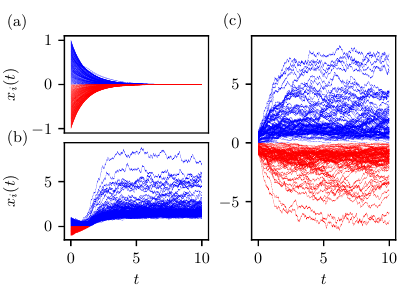

In [56]:
# Define classes
class Agent:
    def __init__(self, opinion, activity):
        self.x=opinion
        self.a=activity
        
    def setOpinion(self, opinion):
        self.x=opinion   
        
    def getOpinion(self):
        return self.x
    
    def setActivity(self, activity):
        self.a=activity
        
    def getActivity(self):
        return self.a
        
class Model:
    def __init__(self, N, a_dist):
        
        x = np.linspace(-1,1,N)
        PowerDistribution = PowerLaw(a=epsilon)
        a = a_dist.rvs(size=N)
        self.network = []
        for i in range(N):
            self.network.append(Agent(x[i], a[i]))

    def __init__(self, N, N_Influencer, a_dist, a_Influencer):
        
        # Initialise N common agents
        x = np.linspace(-1,1,N)
        a = a_dist.rvs(size=N)
        self.network = []
        for i in range(N):
            self.network.append(Agent(x[i], a[i]))
        
        # Initialise N_Influencer influencer agents
        x = np.linspace(-1,1,N_Influencer)
        self.influencers = []
        for i in range(N_Influencer):
            self.influencers.append(Agent(x[i], a_Influencer[i]))
        
            
    def getNetwork(self):
        return self.network
    
    def getInfluencers(self):
        return self.influencers
    
    def getAllOpinions(self):
        allOpinions = np.zeros(len(self.network))
        for i in range(len(self.network)):
            allOpinions[i] = self.network[i].getOpinion()
        return allOpinions
    
    def getInfluencerOpinions(self):
        influencerOpinions = np.zeros(len(self.influencers))
        for i in range(len(self.influencers)):
            influencerOpinions[i] = self.influencers[i].getOpinion()
        return influencerOpinions
    
    def getAllActivities(self):
        allActivities = np.zeros(len(self.network))
        for i in range(len(self.network)):
            allActivities[i] = self.network[i].getActivity()
        return allActivities
    
    def getInfluencerActivities(self):
        influencerActivities = np.zeros(len(self.influencers))
        for i in range(len(self.influencers)):
            influencerActivities[i] = self.influencers[i].getActivity()
        return influencerActivities
    
    def updateAllOpinions(self, newOpinions):
        if len(self.network) == len(newOpinions):
            for i in range(len(self.network)):
                self.network[i].setOpinion(newOpinions[i])
    
    def updateInfluencerOpinions(self, newOpinions):
        if len(self.influencers) == len(newOpinions):
            for i in range(len(self.influencers)):
                self.influencers[i].setOpinion(newOpinions[i])
        
    

class PowerLaw(rv_continuous):
    """Activitiy sampling distribution identical to Baumann et al.
    It models the intuitive assumption, that by far most people
    are hardly posting on social media, and even less people being
    very active. 
    

    For Reference, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.html#scipy.stats.rv_continuous"""
    # define probability distribution as the paper's "F(a)"
    def _pdf(self, x):
        return ((1-gamma)/(1-epsilon**(1-gamma)))*x**(-1*gamma)


In [57]:
# Define methods
from timeit import default_timer

# Implement differential eq. 'dx/dt = [...]'
def diffEq(x, t, alpha, K):
    N=len(x)
    sol = np.zeros(N)
    for index_i, i in enumerate(x):
        sum_tmp = 0
        for index_j, j in enumerate(x):
            sum_tmp +=A[index_i][index_j]*np.tanh(alpha*j)
        sol[index_i] = -i+K*sum_tmp
    return sol


def calculateProbabilities(i, j, x, beta):
    sum_tmp = 0
    for j_tmp in range(len(x)):
        if x[i] != x[j_tmp]:
            sum_tmp = sum_tmp+abs(x[i]-x[j_tmp])**(-beta)
    return (abs(x[i]-x[j])**(-beta))/sum_tmp

def generateContactMatrix(x, beta, m, r):
    rng = default_rng()
    A = np.zeros((len(x), len(x)))
    for index_i, i in enumerate(x):
        sum_tmp=0
        for j in x:
            if i==j: continue
            sum_tmp +=abs(i-j)**(-beta)
        
        for index_j, j in enumerate(x):
            if i==j: continue
            A[index_i][index_j] = (abs(i-j)**(-beta))/sum_tmp
            if m*A[index_i][index_j] > rng.random():
                A[index_i][index_j] = 1
                # Füge recipr. contacting ein:
                if r > rng.random():
                    A[index_j][index_i] = 1
    return A

def generateContactMatrix(model, N, beta, m,m_Influencer, r):
    
    x = np.array(model.getAllOpinions())
    x = np.append(x, model.getInfluencerOpinions())
    a = np.array(model.getAllActivities())
    a = np.append(a, model.getInfluencerActivities())
    
    rng = default_rng()
    A = np.zeros((len(x), len(x)))
    for index_i, i in enumerate(x):
        if a[index_i] < rng.random(): continue
        
        sum_tmp=0
        for j in x:
            if i==j: continue
                # calculate sum used in calculation of contacting probability p_ij
            sum_tmp +=abs(i-j)**(-beta)
        
        for index_j, j in enumerate(x):
            # index to go through different influencer audiences, given in array m_influencer
            c = 0
            
            if i==j or A[index_j][index_i]==1: continue
            A[index_j][index_i] = (abs(i-j)**(-beta))/sum_tmp
            if index_i < N and m*A[index_j][index_i] > rng.random():
                A[index_j][index_i] = 1
                if r > rng.random():
                    A[index_j][index_i] = 1
            elif m_Influencer[c]*A[index_j][index_i] > rng.random():
                c = c+1
                A[index_j][index_i] = 1
                # Füge recipr. contacting ein:
                if r > rng.random():
                    A[index_i][index_j] = 1
    return A


## Model Parameter

In this section the parameter of the model can be changed

In [61]:
# Define fixed parameters
t_current = 0
tMax = 10
dt = 0.01
N = 100
N_Influencer = 7
K=3
# Define different alpha, beta values as arrays from which to pick for each graph
alphas = np.array([0.05, 3, 3])
betas = np.array([2, 0, 3])
alpha_current = alphas[2]
beta_current = betas[2]

# Fixed activity-driving (AD) parameters
m = 1
m_inf=0.2
m_Influencer = np.array((N_Influencer)*[m_inf*N])
a_inf=0.8
a_Influencer = np.full(N_Influencer, a_inf)
epsilon = 0.01
gamma = 2.1
r = 0.5
a_dist=PowerLaw(a=epsilon)

model = Model(N, N_Influencer, a_dist, a_Influencer)
opinionStorage = np.array(model.getAllOpinions())
opinionStorage = np.append(opinionStorage, model.getInfluencerOpinions())

In [62]:
#xecution_start_time = time.time()
print('---\nModel started\n---\n')

# Integrate dynamics with 4th order Runge-Kutta (RK4)

for t in tqdm(np.arange(0, tMax, dt)):
    t_current = t_current + dt
    
    t_RK4 = np.linspace(t_current-dt, t_current, 2)
    A = generateContactMatrix(model, N, beta_current, m, m_Influencer, r)
    currentOpinions = np.array(model.getAllOpinions())
    currentOpinions = np.append(currentOpinions, model.getInfluencerOpinions())
    solODE = odeint(diffEq, currentOpinions, t_RK4, args=(alpha_current, K))
    
    # Update and store new opinions in agents and storage array
    newOpinions = solODE[-1]
    model.updateAllOpinions(newOpinions[:N])
    #model.updateInfluencerOpinions(newOpinions[N:])
    
    newOpinions = np.array(model.getAllOpinions())
    newOpinions = np.append(newOpinions, model.getInfluencerOpinions())
    
    opinionStorage = np.vstack([opinionStorage, newOpinions])

print('\n---\nModel finished\n---')


---
Model started
---



100%|██████████| 1000/1000 [08:00<00:00,  2.08it/s]


---
Model finished
---


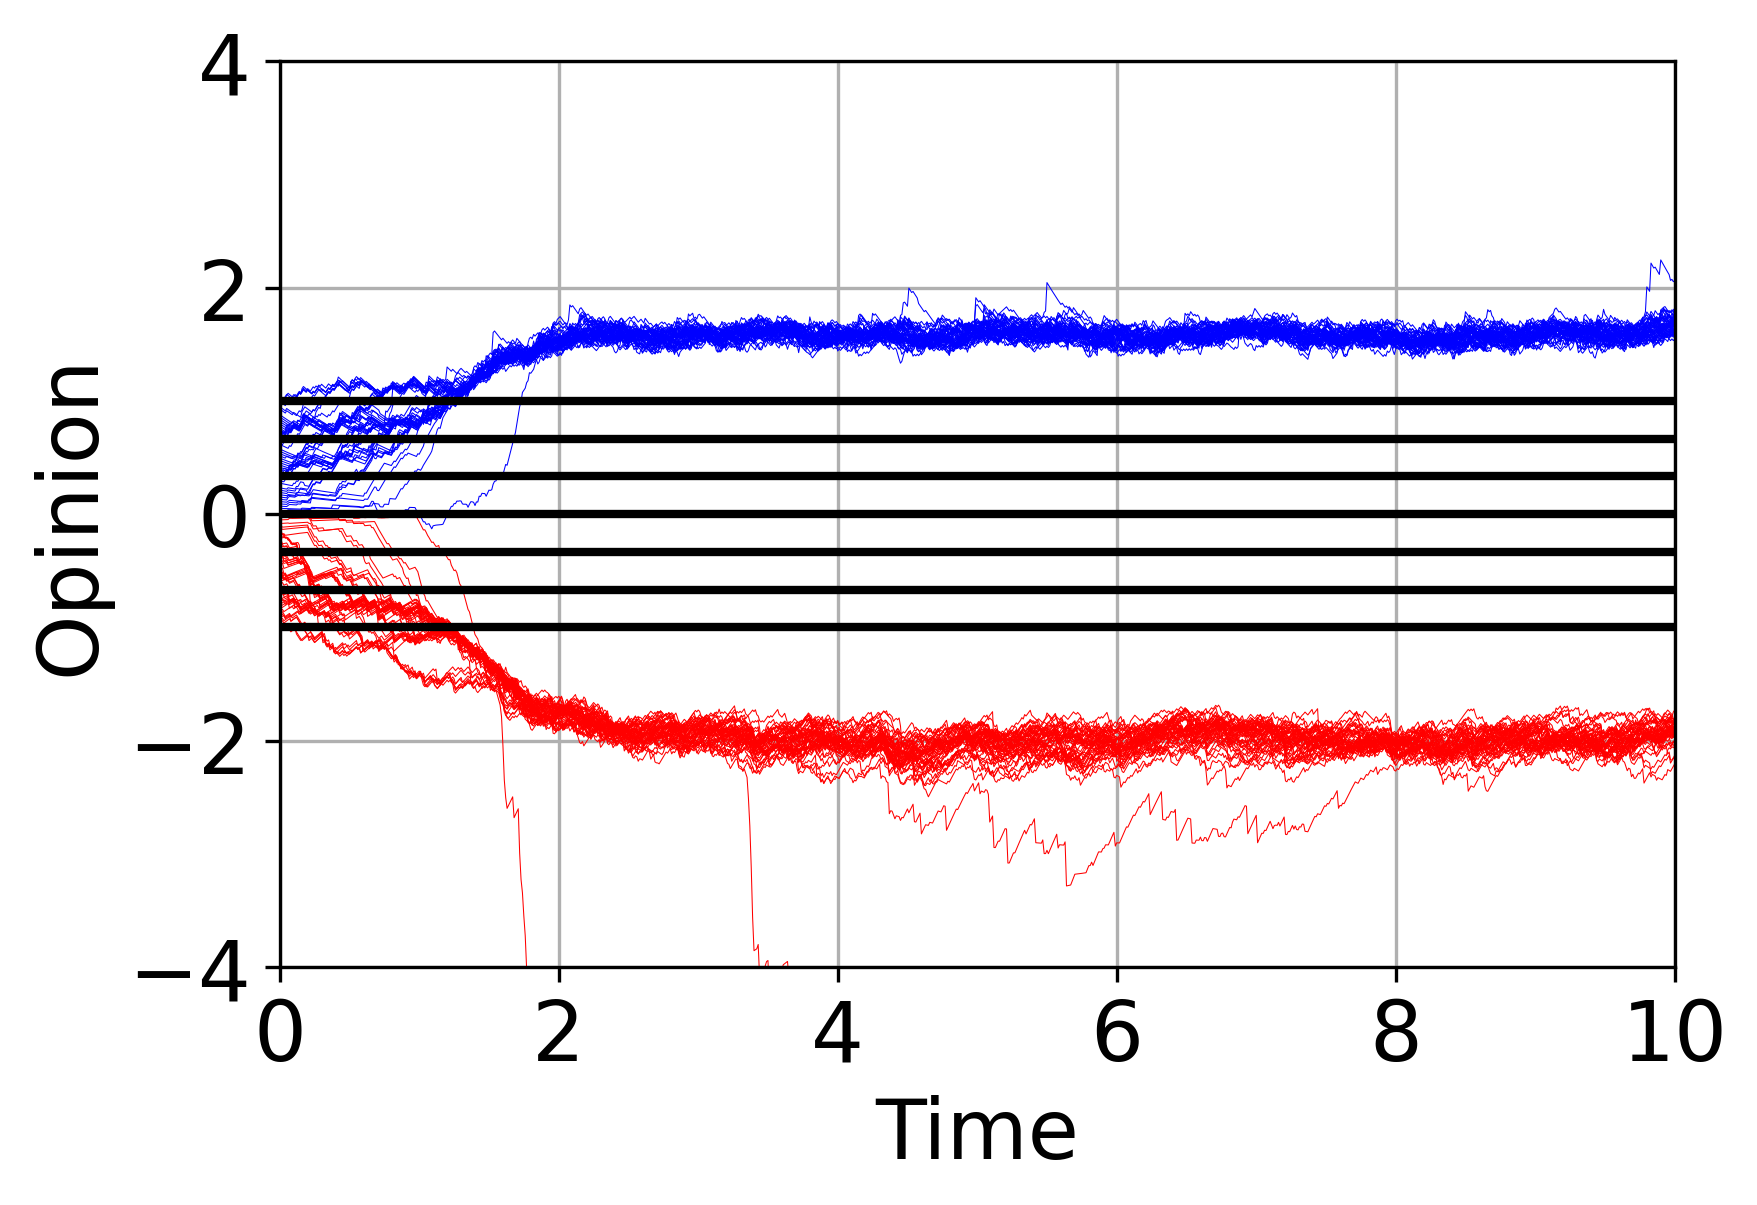

In [63]:
# Plot the results:
plt.close('all')
# Globally change font size for Matplotlib plots
plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.dpi'] = 300
x_influencer= model.getInfluencerOpinions()
# Get time values for plotting out of storage array information
times = np.arange(0, len(opinionStorage)*dt, dt)
# Plot each agent via looping over storage array
opinionStorage.T[2]
for i in range(len(opinionStorage.T)):
    
    # In case the last value of agent i is negative, the graph color will be changed to red 
    if opinionStorage.T[i][-1] < 0:
        color = 'r'
        LW=.25
    else:
        color ='b'
        LW=.25
    # Influencers will be coloured green
    if i>=N: 
        #opinionStorage.T[i]= x_influencer[i-N]
        color = 'black'
        LW=2
    plt.plot(times, opinionStorage.T[i], color, linewidth=LW)
    

             
plt.xlabel('Time')
plt.ylabel('Opinion')

plt.grid()
plt.xlim([0,10])
custom_lines = [Line2D([0], [0], color='r', lw=3),
                Line2D([0], [0], color='b', lw=3),
                Line2D([0], [0], color='g', lw=3)]
#plt.legend(custom_lines, ['negative Agents', 'positive Agents', 'Influencers'], loc='upper left', prop={'size': 7})
plt.ylim([-4, 4])
#plt.xticks([0, 5, 10])
#plt.yticks([-5, 0, 5])

# Uncomment if you do want to save the figure:
file_name = 'Dynamics--N='+str(N)+'--alpha='+str(alpha_current)+'--beta='+str(beta_current)+'--m_inf='+str(m_inf)+'--a_inf='+str(a_inf)+'N_inf=8'
np.savetxt(str('./Results/'+file_name+'.txt'), opinionStorage.T)
plt.savefig(str('./Results/'+file_name+'.png'), bbox_inches='tight')
plt.show()
